# Project 7 - SVM - Bayes
Γεώργιος Δάλλας ΑΕΜ: 217
Ύστερα από πρόσφατες φυσικές καταστροφές, η κυβέρνηση αποφάσισε να βελτιώσει το σύστημα πρόληψης και εκκένωσης με τη βοήθεια αναρτήσεων από το X (Twitter). Πιο συγκεκριμένα, το σύστημα θα εξετάζει αναρτήσεις και σε περίπτωση που κρίνει ότι κάποια φυσική καταστροφή (target=1) βρίσκεται σε εξέλιξη, θα αποστέλλει κατάλληλο μήνυμα μέσω του 112.
# 1. 
Firstly, the train.csv is split into 90/10 tran/test sets. After plotting the amount of 0s and 1s in target feature for train and test, it can be clearly seen that the dataset is only slightly imbalanced.

In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import re
from functools import partial
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA


In [43]:
df_train = pd.read_csv("nlp-getting-started/train.csv")
#df_test = pd.read_csv("nlp-getting-started/test.csv")
input_df = df_train.drop(columns=['target'])
targets_df = df_train['target']
x = input_df.to_numpy()
y = targets_df.to_numpy()
seed = 0
x_train , x_test, y_train , y_test = train_test_split(x, y, test_size=0.1, random_state=seed, stratify=y)


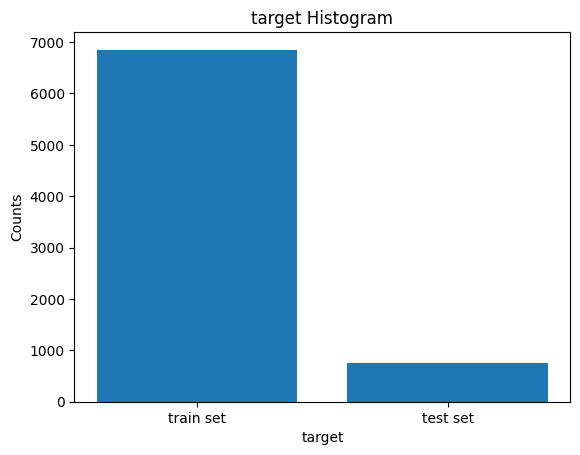

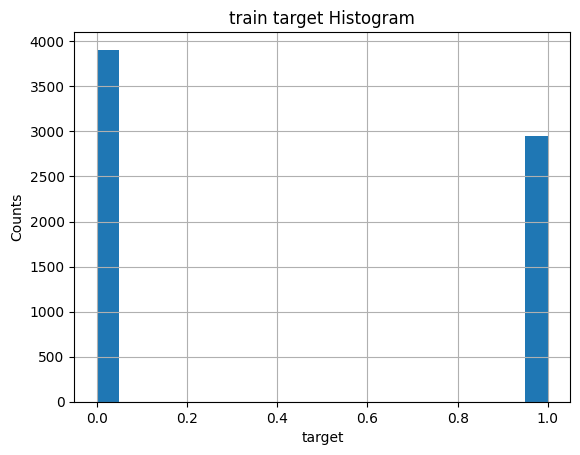

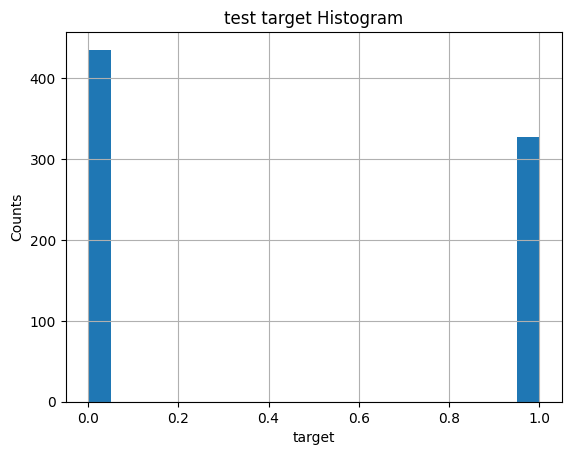

In [44]:
plt.bar(['train set', 'test set'],[len(y_train),len(y_test)])
plt.title('target Histogram')
plt.xlabel('target')
plt.ylabel('Counts')
plt.show()
train_to_hist = pd.DataFrame(y_train)
test_to_hist = pd.DataFrame(y_test)
train_to_hist.hist(bins=20)
plt.title('train target Histogram')
plt.xlabel('target')
plt.ylabel('Counts')
plt.show()


test_to_hist.hist(bins=20)
plt.title('test target Histogram')
plt.xlabel('target')
plt.ylabel('Counts')
plt.show()

## 2.
On this step, id and location features are dropped, when keyword has a missing value it gets filled with "null" and keyword, text are concated into a new feature called input.

In [45]:
#delete id n location
traindf= pd.DataFrame(x_train)
testdf = pd.DataFrame(x_test)
traindf.head(1)

,0,1,2,3
0,9557,threat,"BiÌ±an,Laguna",Meek Mill responds to DrakeÛªs OVO Fest set w...


In [46]:
traindf=traindf.drop([0,2],axis=1)
testdf=testdf.drop([0,2],axis=1)
#keyword nan -> "null"
print(traindf.head())

traindf = traindf.fillna("null")
testdf= testdf.fillna("null")
traindf['input'] = traindf[1] + '' + traindf[3]
testdf['input'] = testdf[1] + '' +testdf[3]
traindf.head()


           1                                                  3
0     threat  Meek Mill responds to DrakeÛªs OVO Fest set w...
1      flood  survived the plague\nfloated the flood\njust p...
2    weapons  #Kick Hendrixonfire  @'=BLACKCATS= | BIG NOOB ...
3     deluge  Vince McMahon once again a billionaire: I reme...
4  hazardous  Is it possible to sneak into a hospital so I c...


,1,3,input
0,threat,Meek Mill responds to DrakeÛªs OVO Fest set w...,threatMeek Mill responds to DrakeÛªs OVO Fest...
1,flood,survived the plague\nfloated the flood\njust p...,floodsurvived the plague\nfloated the flood\nj...
2,weapons,#Kick Hendrixonfire @'=BLACKCATS= | BIG NOOB ...,weapons#Kick Hendrixonfire @'=BLACKCATS= | BI...
3,deluge,Vince McMahon once again a billionaire: I reme...,delugeVince McMahon once again a billionaire: ...
4,hazardous,Is it possible to sneak into a hospital so I c...,hazardousIs it possible to sneak into a hospit...


# 3. Text preprocessing:

- Removed Unicode Strings (function removeUnicode): a function that gets a text and removes with regex unicode strings like \u002c or x96. Used to remove unusual characters from X's texts.
- Replaced URLs (function replaceURL): a function that replaces url with a string saying "url". This is used since the url holds no semantic value when our model cant access its contents.
- Replaced @User (function replaceAtUser): function that replaces @User with a general "AtUser" string, used since we dont care / don't navigate to the actual users.
- (function removeHashtagInFrontOfWord): a function that removes a hastag in front of the word and turns it to itts content. Used so the text can actually understand it's the same thing with the word.
- Remove Numbers (function removeNumbers): it removes integers in the text. Numbers wont hold any meaning most of the time and can actually confuse things when trying to determine for hazards or not since they are not correlated with the task.
- Replace Repetitions of Punctuation (functions replaceMultiExclamationMark, replaceMultiQuestionMark, replaceMultiStopMark): repeations of those things wont hold any significant meaning, it's important though to keep text as homogeneous as possible.
- (replaceSlang): replaces slang words with their actual formal word from a txt. Used to make the texts more consistant to each other.
-  (function replaceContraction): used to replace contractions like won't to will not, so texts are as consistant as possible since those things hold the same meaning with different tone.

In [47]:


def removeUnicode(text):
    """ Removes unicode strings like "\u002c" and "x96" """
    text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)       
    text = re.sub(r'[^\x00-\x7f]',r'',text)
    return text

def replaceURL(text):
    """ Replaces url address with "url" """
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',text)
    text = re.sub(r'#([^\s]+)', r'\1', text)
    return text
def replaceAtUser(text):
    """ Replaces "@user" with "atUser" """
    text = re.sub('@[^\s]+','atUser',text)
    return text

def removeHashtagInFrontOfWord(text):
    """ Removes hastag in front of a word """
    text = re.sub(r'#([^\s]+)', r'\1', text)
    return text

def removeNumbers(text):
    """ Removes integers """
    text = ''.join([i for i in text if not i.isdigit()])         
    return text

def replaceMultiExclamationMark(text):
    """ Replaces repetitions of exlamation marks """
    text = re.sub(r"(\!)\1+", ' multiExclamation ', text)
    return text

def replaceMultiQuestionMark(text):
    """ Replaces repetitions of question marks """
    text = re.sub(r"(\?)\1+", ' multiQuestion ', text)
    return text

def replaceMultiStopMark(text):
    """ Replaces repetitions of stop marks """
    text = re.sub(r"(\.)\1+", ' multiStop ', text)
    return text


""" Creates a dictionary with slangs and their equivalents and replaces them """
with open('slang.txt') as file:
    slang_map = dict(map(str.strip, line.partition('\t')[::2])
    for line in file if line.strip())

slang_words = sorted(slang_map, key=len, reverse=True) # longest first for regex
regex = re.compile(r"\b({})\b".format("|".join(map(re.escape, slang_words))))
replaceSlang = partial(regex.sub, lambda m: slang_map[m.group(1)])

""" Replaces contractions from a string to their equivalents """
contraction_patterns = [ (r'won\'t', 'will not'), (r'can\'t', 'cannot'), (r'i\'m', 'i am'), (r'ain\'t', 'is not'), (r'(\w+)\'ll', '\g<1> will'), (r'(\w+)n\'t', '\g<1> not'),
                         (r'(\w+)\'ve', '\g<1> have'), (r'(\w+)\'s', '\g<1> is'), (r'(\w+)\'re', '\g<1> are'), (r'(\w+)\'d', '\g<1> would'), (r'&', 'and'), (r'dammit', 'damn it'), (r'dont', 'do not'), (r'wont', 'will not') ]
def replaceContraction(text):
    patterns = [(re.compile(regex), repl) for (regex, repl) in contraction_patterns]
    for (pattern, repl) in patterns:
        (text, count) = re.subn(pattern, repl, text)
    return text



In [48]:

def full_preprocess(text):
    text = removeUnicode(text)
    text = replaceURL(text)
    text = replaceAtUser(text)
    text = removeHashtagInFrontOfWord(text)
    text = removeNumbers(text)
    text = replaceMultiExclamationMark(text)
    text = replaceMultiQuestionMark(text)
    text = replaceMultiStopMark(text)
    text = replaceSlang(text)
    text = replaceContraction(text)
    return text


traindf['input'] =  traindf['input'].apply(full_preprocess)
testdf['input'] = testdf['input'].apply(full_preprocess)

# 4. 
inputs and targets are transformed into numpy arrays.

In [49]:
x_train = traindf['input'].to_numpy()
x_test = testdf['input'].to_numpy()


# 5.
TfIDFVectorizer is used to compute the tf-idf of each word.

In [50]:

vectorizer = TfidfVectorizer()


tfidf_xtrain= vectorizer.fit_transform(x_train)


print(vectorizer.get_feature_names_out())




tfidf_xtest = vectorizer.transform(x_test)



['__' '_andgt' '_andlt' ... 'zumiez' 'zurich' 'zzzz']


# 6.
LinearSVC is trained using tfidf_xtrain and y_train and it's accuracy, f1, precision and recall are printed. Precision is really important since we care about not having false positives.

In [51]:
svm = LinearSVC()

svm.fit(tfidf_xtrain,y_train)
y_pred = svm.predict(tfidf_xtest)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)  
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Accuracy",accuracy)
print("Precision",precision)
print("Recall",recall)
print("F1 Score",f1)


Accuracy 0.7952755905511811
Precision 0.77491961414791
Recall 0.7370030581039755
F1 Score 0.7554858934169278


# 7.
to keep 95% of information (varience) we need 4422 components. LinearSVM after pca performed slightly worse and rbf svm performed slightly worse in f1 from the linear one.

(6851, 16886)


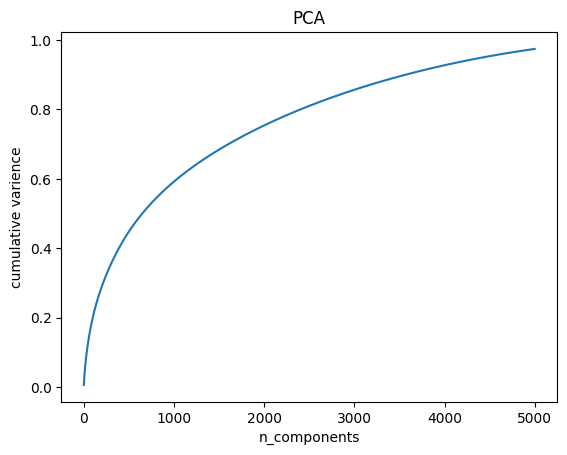

In [52]:
print(tfidf_xtrain.shape)
pca = PCA(n_components=5000)
xtrain_pca = pca.fit_transform(tfidf_xtrain)
xtest_pca = pca.transform(tfidf_xtest)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure()
plt.plot(cumulative_variance)
plt.xlabel("n_components")
plt.ylabel("cumulative varience")
plt.title("PCA")
plt.show()

In [55]:
n_components = np.argmax(cumulative_variance >= 0.95)
print(n_components)

4422


In [60]:
pca = PCA(n_components=4422)
x_train_pca = pca.fit_transform(tfidf_xtrain)
x_test_pca = pca.transform(tfidf_xtest)



In [71]:
lsvm = LinearSVC()

svm.fit(x_train_pca,y_train)
y_pred = svm.predict(x_test_pca)
accuracy1 = accuracy_score(y_test, y_pred)
precision1 = precision_score(y_test, y_pred)  
recall1 = recall_score(y_test, y_pred)
f11 = f1_score(y_test, y_pred)
print("Accuracy",accuracy1)
print("Precision",precision1)
print("Recall",recall1)
print("F1 Score",f1)

from sklearn.svm import SVC

rbfsvc = SVC(kernel='rbf')
rbfsvc.fit(x_train_pca,y_train)
y_pred = svm.predict(x_test_pca)
accuracy2 = accuracy_score(y_test, y_pred)
precision2 = precision_score(y_test, y_pred)  
recall2 = recall_score(y_test, y_pred)
f12 = f1_score(y_test, y_pred)
print("Accuracy",accuracy2)
print("Precision",precision2)
print("Recall",recall2)
print("F1 Score",f12)


Accuracy 0.7847769028871391
Precision 0.7570977917981072
Recall 0.7339449541284404
F1 Score 0.7554858934169278
Accuracy 0.7847769028871391
Precision 0.7570977917981072
Recall 0.7339449541284404
F1 Score 0.7453416149068323


# 8.
gamma in scale is 1.066 and in auto is 0.0002. The huge difference happens since scale multiplies features with varience.

In [62]:
rbfsvc = SVC(kernel='rbf',gamma='auto')
rbfsvc.fit(x_train_pca,y_train)
y_pred = svm.predict(x_test_pca)
accuracy3 = accuracy_score(y_test, y_pred)
precision3 = precision_score(y_test, y_pred)  
recall3 = recall_score(y_test, y_pred)
f13 = f1_score(y_test, y_pred)
print("Accuracy",accuracy3)
print("Precision",precision3)
print("Recall",recall3)
print("F1 Score",f13)

Accuracy 0.7847769028871391
Precision 0.7570977917981072
Recall 0.7339449541284404
F1 Score 0.7453416149068323


In [73]:
print("gamma scale = ",1/(x_train_pca.var()*4422))
print("gamma auto = ",1/4422)

gamma scale =  1.0661642160973253
gamma auto =  0.0002261420171867933


The bar plot shows that the overall difference between the models is really low.

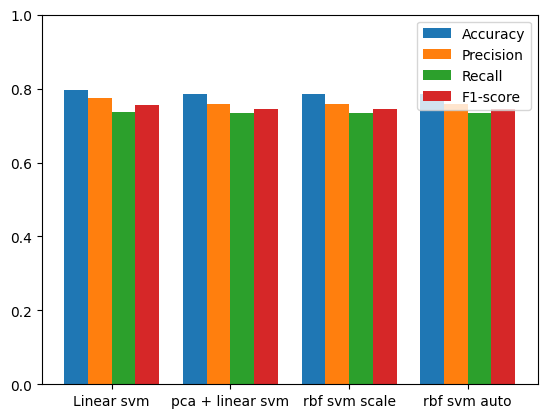

In [70]:

accuracy_list = [accuracy, accuracy1, accuracy2, accuracy3]
precision_list = [precision, precision1, precision2, precision3]
recall_list = [recall, recall1, recall2, recall3]
f1_list = [f1, f11, f12, f13]
metrics = np.array([accuracy_list, precision_list, recall_list, f1_list])

plt.bar(np.arange(4), metrics[0], width=0.2, label='Accuracy')
plt.bar(np.arange(4)+0.2, metrics[1], width=0.2, label='Precision')
plt.bar(np.arange(4)+0.4, metrics[2], width=0.2, label='Recall')
plt.bar(np.arange(4)+0.6, metrics[3], width=0.2, label='F1-score')
plt.xticks(np.arange(4)+0.3, ['Linear svm','pca + linear svm','rbf svm scale','rbf svm auto'])
plt.ylim(0,1)
plt.legend()
plt.show()

# 9.
Naive Bayes performed worse than the simple linear svm.

In [75]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(tfidf_xtrain.toarray(),y_train)
y_pred = nb.predict(tfidf_xtest.toarray())
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)  
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Accuracy",accuracy)
print("Precision",precision)
print("Recall",recall)
print("F1 Score",f1)

Accuracy 0.6627296587926509
Precision 0.578125
Recall 0.7920489296636085
F1 Score 0.6683870967741935
